In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import dirname
from pandas import DataFrame, read_csv, concat
from tqdm import tqdm
ROOT_DIR = dirname(dirname(os.path.realpath('__file__')))
sns.set_theme(style='ticks', context='notebook', font_scale=1.2)

## Section 1: Behavior

In [2]:
## Load data.
data = concat([read_csv(os.path.join('data', session, 'pgng.csv'))
               for session in ['s1','s2','s3']])

## Restrict participants.
reject = read_csv(os.path.join('data', 's1', 'reject.csv'))
data = data[data.subject.isin(reject.query('reject==0').subject)].reset_index(drop=True)

## Return number of participants per session.
print(data.groupby('session').subject.nunique())

session
1    110
2     97
3     99
Name: subject, dtype: int64


### 1.1 Learning curves

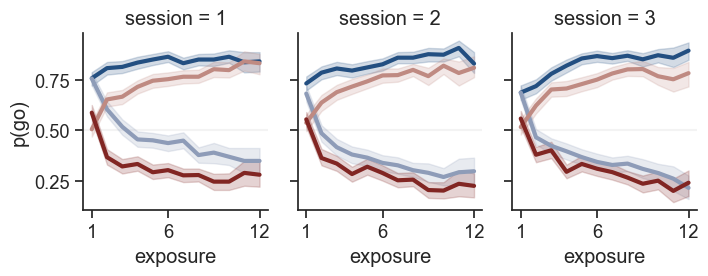

In [3]:
## Initialize canvas.
g = sns.FacetGrid(data, col='session', col_order=[1,2,3], aspect=0.8)

## Define aesthetics.
palette = ['#234f81', '#8e9cb8', '#bf8a82', '#812623']
hue_order = ['gw','ngw','gal','ngal']

## Plot learning curves.
g.map(sns.lineplot, 'exposure', 'choice', 'robot', hue_order=hue_order, palette=palette, 
      lw=3, errorbar=('ci', 95))

## Add trend line.
for ax in g.axes.flatten(): ax.axhline(0.5, color='k', alpha=0.05, zorder=-1)

## Adjust x-axis.
g.set(xticks=[1,6,12])
g.set_xlabels('exposure')

## Adjust y-axis.
g.set_ylabels('p(go)');

### 1.2 Descriptive statistics

In [4]:
from itertools import combinations

## Define parameters.
n_iter = 5000
sessions = [1,2,3]
pairs = list(combinations(sessions, 2))

## Define convenience functions.
def mad(x):
    """Median absolute difference."""
    return np.nanmedian(np.abs(x - np.nanmedian(x)))

def cohens_d(x, popmean=0):
    """Cohen's D for one-sample median."""
    return np.abs(np.nanmedian(x) - popmean) / (mad(x) / 0.6745)

def resample(x):
    """Bootstrap resampling."""
    return np.random.choice(x, len(x), replace=True)

#### 1.2.1 Overall performance

**Within-session comparisons**

In [5]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance (adjusted for midpoint).
pivot = data.pivot_table('accuracy', 'subject', 'session') - 0.5

## Compute observed effects.
obs = pivot.median().values + 0.5

## Compute effect sizes.
d = pivot.apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    null[n] = df.median().values
    
## Compute confidence intervals.
lb, ub = np.percentile(null, [2.5, 97.5], 0) + 0.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute sign.
    pivot = pivot * np.random.choice([1,-1], pivot.shape, replace=True)
    
    ## Compute observed effects.
    null[n] = pivot.median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:05<00:00, 901.23it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.675,1.828,0.0,0.658,0.690
2,0.717,2.063,0.0,0.696,0.746
3,0.696,1.441,0.0,0.665,0.738


**Between-session comparisons**

In [6]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance (adjusted for midpoint).
pivot = data.pivot_table('accuracy', 'subject', 'session')

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
     ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])
        
## Compute confidence intervals.
lb, ub = np.percentile(null, [2.5, 97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:17<00:00, 278.33it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2  -0.021  0.337  0.003  0.009 -0.033 -0.004
   3  -0.012  0.156  0.146  0.344 -0.019  0.012
2  3   0.008  0.135  0.335  0.685 -0.008  0.021

#### 1.2.2 Main effect: required action

**Within-session comparisons**

In [7]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'action')

## Compute observed effects.
obs = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['go'] - pivot['no-go']).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df['go'] - df['no-go']).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:37<00:00, 133.57it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.192,1.108,0.0,0.150,0.225
2,0.133,0.899,0.0,0.100,0.150
3,0.142,0.882,0.0,0.075,0.175


**Between-session comparisons**

In [8]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', ['action','session'])
pivot = pivot['go'] - pivot['no-go']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:17<00:00, 283.72it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2   0.050  0.405  0.002  0.007  0.017  0.088
   3   0.058  0.429  0.001  0.003  0.025  0.087
2  3   0.025  0.202  0.162  0.382 -0.012  0.042

#### 1.2.3 Main effect: outcome valence

**Within-session comparisons**

In [9]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by outcome valence.
pivot = data.pivot_table('accuracy', ['session','subject'], 'valence')

## Compute observed effects.
obs = (pivot['win'] - pivot['lose']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['win'] - pivot['lose']).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df['win'] - df['lose']).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['win'] - pivot['lose']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:37<00:00, 132.61it/s]


,obs,d,pval,lb,ub
session,,,,,
1,-0.025,0.289,0.002,-0.042,0.008
2,0.008,0.096,0.245,-0.008,0.033
3,0.025,0.337,0.004,0.000,0.042


**Between-session comparisons**

In [10]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by outcome valence.
pivot = data.pivot_table('accuracy', 'subject', ['valence','session'])
pivot = pivot['win'] - pivot['lose']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:17<00:00, 278.39it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2  -0.033  0.300  0.037  0.096 -0.050  0.000
   3  -0.050  0.450  0.001  0.002 -0.071 -0.025
2  3  -0.008  0.075  0.493  0.851 -0.042  0.025

#### 1.2.4 Interaction effect: action type X outcome valence

**Within-session comparisons**

In [11]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', ['session','subject'], 'congruence')

## Compute observed effects.
obs = (pivot['c'] - pivot['i']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['c'] - pivot['i']).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df['c'] - df['i']).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['c'] - pivot['i']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:40<00:00, 124.16it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.125,1.065,0.0,0.100,0.150
2,0.083,0.843,0.0,0.067,0.100
3,0.075,0.867,0.0,0.050,0.092


**Between-session comparisons**

In [12]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', 'subject', ['congruence','session'])
pivot = pivot['c'] - pivot['i']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:18<00:00, 269.90it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2   0.042  0.281  0.008  0.027  0.008  0.079
   3   0.042  0.337  0.010  0.027  0.008  0.071
2  3   0.000  0.000  0.840  0.997 -0.033  0.042

#### 1.2.5 Secondary effect: feedback type 

**Within-session comparisons**

In [13]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define previous exposure.
data['prev_sham'] = data.groupby(['subject','session','stimulus']).sham.transform(np.roll, 1)
data.loc[data.exposure == 1, 'prev_sham'] = np.nan

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'prev_sham')

## Compute observed effects.
obs = (pivot[0] - pivot[1]).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot[0] - pivot[1]).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df[0] - df[1]).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot[0] - pivot[1]).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:37<00:00, 132.58it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.282,2.254,0.0,0.257,0.309
2,0.294,2.142,0.0,0.247,0.320
3,0.268,2.267,0.0,0.241,0.294


**Between-session comparisons**

In [14]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', 'subject', ['prev_sham','session'])
pivot = pivot[0] - pivot[1]

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:17<00:00, 278.95it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2   0.017  0.139  0.297  0.632 -0.010  0.046
   3   0.008  0.057  0.628  0.942 -0.022  0.049
2  3   0.021  0.132  0.186  0.461 -0.034  0.037

#### 1.2.6 Secondary effect: font type

**Overall accuracy**

In [15]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define pairs.
pairs = list(combinations(['bacs1','bacs2','elianto'], 2))

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'rune_set')

## Compute observed effects.
obs = np.array([pivot[a].median() - pivot[b].median() for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = pivot[a].median() - pivot[b].median()

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = pivot[a].median() - pivot[b].median()
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:42<00:00, 116.78it/s]


obs   pval   fwer     lb     ub
s1    s2                                        
bacs1 bacs2    0.004  0.827  0.964  0.004  0.004
      elianto -0.002  0.914  0.981 -0.002 -0.002
bacs2 elianto -0.006  0.774  0.949 -0.006 -0.006

### 1.3 Individual-differences

In [16]:
from scipy.stats import chi2_contingency

## Compute accuracy by participant / session / condition.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()

## Score performance into top five deciles.
gb['score'] = np.digitize(gb.accuracy, [0.6,0.9])

## Calculate proportion of participants in each bin.
pivot = gb.pivot_table('subject', ['robot','score'], 'session', aggfunc='count').fillna(0)

for robot in ['gw','ngw','gal','ngal']:
    chi2, pval, dof, _ = chi2_contingency(pivot.loc[robot])
    print('%s\tx2(df=%s) = %0.3f (p = %0.3f)' %(robot, dof, chi2, pval))

gw	x2(df=4) = 1.163 (p = 0.884)
ngw	x2(df=4) = 13.343 (p = 0.010)
gal	x2(df=4) = 6.499 (p = 0.165)
ngal	x2(df=4) = 5.097 (p = 0.278)


### 1.4 Comparison to Experiment 1

In [17]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

## Main loop.
data = []
for study in [1,2]:

    ## Define study directory.
    STUDY_DIR = os.path.join(ROOT_DIR, f'study0{study}')

    ## Load data.
    df = concat([read_csv(os.path.join(STUDY_DIR, 'data', session, 'pgng.csv'))
                 for session in ['s1','s2','s3']])

    ## Restrict participants.
    reject = read_csv(os.path.join(STUDY_DIR, 'data', 's1', 'reject.csv'))
    df = df[df.subject.isin(reject.query('reject==0').subject)].reset_index(drop=True)

    ## Append DataFrame.
    df.insert(0, 'study', study)
    data.append(df)

## Concatenate DataFrames.
data = concat(data)

#### 1.4.1 Overall performance

In [18]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance.
pivot = data.groupby(['study','session','subject']).accuracy.mean().reset_index()

## Compute effect.
pivot = pivot.rename(columns={'accuracy': 'effect'})

## Compute observed effects.
model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
obs = anova_lm(model, typ=2).dropna()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, 3))
for n in tqdm(range(n_iter)):
    
    ## Permute labels.
    pivot = pivot.pivot_table('effect', ['study', 'subject'], 'session').reset_index()
    pivot['study'] = np.random.permutation(pivot.study)
    pivot = pivot.melt(id_vars=['study','subject'], var_name='session', value_name='effect')
    pivot['session'] = pivot.groupby('subject').session.transform(np.random.permutation)
    
    ## Compute null effects.
    model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
    anova = anova_lm(model, typ=2)
    null[n] = anova.F.values[:3]

## Compute p-values.
pval = (np.sum(obs.F.values.reshape(1,-1) < null, axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Update p-values to reflect permutation test.
obs.loc[:,obs.columns[-1]] = pval

## Report results.
obs

100%|███████████████████████████████████████| 5000/5000 [00:54<00:00, 92.45it/s]


,sum_sq,df,F,PR(>F)
C(study),4.238062,1.0,402.977993,0.0002
C(session),0.326035,2.0,15.500610,0.0002
C(study):C(session),0.118128,2.0,5.616136,0.0002


#### 1.4.2 Main effect: required action

In [19]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', ['study','session','subject'], 'action')

## Compute action bias. 
pivot['effect'] = pivot['go'] - pivot['no-go']
pivot = pivot.reset_index()

## Compute observed effects.
model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
obs = anova_lm(model, typ=2).dropna()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, 3))
for n in tqdm(range(n_iter)):
    
    ## Permute labels.
    pivot = pivot.pivot_table('effect', ['study', 'subject'], 'session').reset_index()
    pivot['study'] = np.random.permutation(pivot.study)
    pivot = pivot.melt(id_vars=['study','subject'], var_name='session', value_name='effect')
    pivot['session'] = pivot.groupby('subject').session.transform(np.random.permutation)
    
    ## Compute null effects.
    model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
    anova = anova_lm(model, typ=2)
    null[n] = anova.F.values[:3]

## Compute p-values.
pval = (np.sum(obs.F.values.reshape(1,-1) < null, axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Update p-values to reflect permutation test.
obs.loc[:,obs.columns[-1]] = pval

## Report results.
obs

100%|███████████████████████████████████████| 5000/5000 [00:54<00:00, 91.43it/s]


,sum_sq,df,F,PR(>F)
C(study),0.477266,1.0,24.711221,0.000800
C(session),0.483817,2.0,12.525215,0.000200
C(study):C(session),0.018151,2.0,0.469912,0.429914


#### 1.4.3 Main effect: outcome valence

In [20]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', ['study','session','subject'], 'valence')

## Compute action bias. 
pivot['effect'] = pivot['win'] - pivot['lose']
pivot = pivot.reset_index()

## Compute observed effects.
model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
obs = anova_lm(model, typ=2).dropna()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, 3))
for n in tqdm(range(n_iter)):
    
    ## Permute labels.
    pivot = pivot.pivot_table('effect', ['study', 'subject'], 'session').reset_index()
    pivot['study'] = np.random.permutation(pivot.study)
    pivot = pivot.melt(id_vars=['study','subject'], var_name='session', value_name='effect')
    pivot['session'] = pivot.groupby('subject').session.transform(np.random.permutation)
    
    ## Compute null effects.
    model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
    anova = anova_lm(model, typ=2)
    null[n] = anova.F.values[:3]

## Compute p-values.
pval = (np.sum(obs.F.values.reshape(1,-1) < null, axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Update p-values to reflect permutation test.
obs.loc[:,obs.columns[-1]] = pval

## Report results.
obs

100%|███████████████████████████████████████| 5000/5000 [00:54<00:00, 92.08it/s]


,sum_sq,df,F,PR(>F)
C(study),0.000039,1.0,0.005722,0.944811
C(session),0.059788,2.0,4.400147,0.008998
C(study):C(session),0.041717,2.0,3.070207,0.038192


#### 1.4.4 Interaction effect: action type X outcome valence

In [21]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by action type.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', ['study','session','subject'], 'congruence')

## Compute action bias. 
pivot['effect'] = pivot['c'] - pivot['i']
pivot = pivot.reset_index()

## Compute observed effects.
model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
obs = anova_lm(model, typ=2).dropna()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, 3))
for n in tqdm(range(n_iter)):
    
    ## Permute labels.
    pivot = pivot.pivot_table('effect', ['study', 'subject'], 'session').reset_index()
    pivot['study'] = np.random.permutation(pivot.study)
    pivot = pivot.melt(id_vars=['study','subject'], var_name='session', value_name='effect')
    pivot['session'] = pivot.groupby('subject').session.transform(np.random.permutation)
    
    ## Compute null effects.
    model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
    anova = anova_lm(model, typ=2)
    null[n] = anova.F.values[:3]

## Compute p-values.
pval = (np.sum(obs.F.values.reshape(1,-1) < null, axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Update p-values to reflect permutation test.
obs.loc[:,obs.columns[-1]] = pval

## Report results.
obs

100%|███████████████████████████████████████| 5000/5000 [00:54<00:00, 92.48it/s]


,sum_sq,df,F,PR(>F)
C(study),0.170541,1.0,13.960298,0.002999
C(session),0.420395,2.0,17.206541,0.000200
C(study):C(session),0.012626,2.0,0.516785,0.500300


#### 1.4.5 Secondary effect: feedback type 


In [22]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define previous exposure.
data['prev_sham'] = data.groupby(['study','subject','session','stimulus']).sham.transform(np.roll, 1)
data.loc[data.exposure == 1, 'prev_sham'] = np.nan

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', ['study','session','subject'], 'prev_sham')

## Compute action bias. 
pivot['effect'] = pivot[0] - pivot[1]
pivot = pivot.reset_index()

## Compute observed effects.
model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
obs = anova_lm(model, typ=2).dropna()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, 3))
for n in tqdm(range(n_iter)):
    
    ## Permute labels.
    pivot = pivot.pivot_table('effect', ['study', 'subject'], 'session').reset_index()
    pivot['study'] = np.random.permutation(pivot.study)
    pivot = pivot.melt(id_vars=['study','subject'], var_name='session', value_name='effect')
    pivot['session'] = pivot.groupby('subject').session.transform(np.random.permutation)
    
    ## Compute null effects.
    model = ols('effect ~ C(study) + C(session) + C(study):C(session)', data=pivot).fit()
    anova = anova_lm(model, typ=2)
    null[n] = anova.F.values[:3]

## Compute p-values.
pval = (np.sum(obs.F.values.reshape(1,-1) < null, axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Update p-values to reflect permutation test.
obs.loc[:,obs.columns[-1]] = pval

## Report results.
obs

100%|███████████████████████████████████████| 5000/5000 [00:54<00:00, 91.78it/s]


,sum_sq,df,F,PR(>F)
C(study),6.451974,1.0,510.052738,0.0002
C(session),0.087926,2.0,3.475440,0.0004
C(study):C(session),0.074909,2.0,2.960936,0.0004
